In [1]:
import os
# Use Either one of these as backend.
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "torch"

In [2]:
from fastvit import fastvit_t8, fastvit_t12, fastvit_s12, fastvit_sa12, fastvit_sa24, fastvit_sa36, fastvit_ma36

In [3]:
import torch
import fnmatch

In [4]:
class WeightsLayerIterator:
    def __init__(self, pytorch_weights, keras_model):
        self.keras_model = keras_model
        self.pytorch_weights = pytorch_weights
        self.keras_layer_is_depthwise = False
        self.keras_layer_is_einsum = False

    def get_next_pytorch_weight(self):
        count = 0
        for idx, (param_name, param) in enumerate(self.pytorch_weights.items()):

            sentence = "{count} {param_name} ----> {param_shape}"
            if "num_batches_tracked" in param_name:
                continue

            if "conv.weight" in param_name:
                if self.keras_layer_is_depthwise:
                    param = param.permute(2, 3, 0, 1)
                else:
                    param = param.permute(2, 3, 1, 0)

            elif ("layer_scale" in param_name) or (len(param.shape) == 2):
                param = param.permute(*torch.arange(param.ndim - 1, -1, -1))

            elif (
                fnmatch.fnmatch(param_name, "*convffn.fc*.weight")
                or fnmatch.fnmatch(param_name, "*se.*.weight") # Squeeze-Excitation
                or fnmatch.fnmatch(param_name, "*6.pe.weight") # rep_cpe/conv2d_114/kernel
            ):
                param = param.permute(3, 2, 1, 0)

            count += 1
            yield sentence.format(
                count=count, param_name=param_name, param_shape=param.shape
            ), param
            # yield sentence.format(count=count, param_name=param_name, param_shape=param.shape)

    def get_keras_weight(self):
        count = 0
        for idx, param in enumerate(self.keras_model.variables):
            if "seed_generator_state" in param.path:
                continue

            self.keras_layer_is_depthwise = True if "depthwise_conv2d" in param.path else False

            count += 1
            yield f"{count} {param.path} ----> {param.shape}", param
            # yield f"{count} {param.path} ----> {param.shape}"


In [5]:
def get_pytorch2keras_layer_weights_mapping(pytorch_weights, keras_model):
    wl = WeightsLayerIterator(pytorch_weights=pytorch_weights, keras_model=keras_model)
    layer_mapping = {}

    for idx, ((keras_sentence, keras_weight), (pytorch_sentence, pytorch_weight)) in enumerate(zip(wl.get_keras_weight(), wl.get_next_pytorch_weight())):
        # print(keras_sentence, "True" if wl.keras_layer_is_depthwise else "")
        # print(pytorch_sentence)

        if "depthwise_conv2d" in keras_sentence:
            new_pytorch_weight_shape = (pytorch_weight.shape[0], pytorch_weight.shape[1], -1, pytorch_weight.shape[2] // keras_weight.shape[2])   
            pytorch_weight = pytorch_weight.reshape(new_pytorch_weight_shape)

        if keras_weight.shape != pytorch_weight.shape:
            print(keras_sentence)
            print(pytorch_sentence)        
            # print(f"New :: keras:: {keras_weight.shape}, pytorch: {pytorch_weight.shape}")
            print("-------------")
        # print()
        keras_layer_name = keras_weight.path.split("/")[0]
        layer_mapping.setdefault(keras_layer_name, list())
        layer_mapping[keras_layer_name].append(pytorch_weight.numpy())

    return layer_mapping

In [6]:
def load_weights_in_keras_model(keras_model, layer_mapping):
    for keras_layer in keras_model.layers[1:]:
        keras_layer_name = keras_layer.name

        if "global_average_pooling2d" in keras_layer_name:
            continue

        if "dropout" in keras_layer.name:
            continue

        from_pt = list(layer_mapping[keras_layer_name])

        keras_model.get_layer(keras_layer_name).set_weights(from_pt)
    return keras_model

In [7]:
import numpy as np


def weights_port_agg(pytorch_weights_path, keras_models_types, save_name_prefix="keras", img_shape=(256, 256, 3), save_dir="."):
    os.makedirs(save_dir, exist_ok=True)
    for idx, (pytorch_weights_path, keras_models_type) in enumerate(zip(pytorch_weights_path, keras_models_types)):
        # load weights and build keras model
        print("Porting weights for model:", keras_models_type.__name__)
        pytorch_weights = torch.load(pytorch_weights_path, map_location="cpu", weights_only=True)["state_dict"]
        keras_model = keras_models_type()

        # get weight 2 layer mapping.
        layer_mapping = get_pytorch2keras_layer_weights_mapping(
            pytorch_weights=pytorch_weights,
            keras_model=keras_model,
        )

        # load weights in keras model.
        keras_model = load_weights_in_keras_model(keras_model=keras_model, layer_mapping=layer_mapping)
        
        # save model weights        
        save_name = f"{save_name_prefix}_{os.path.splitext(os.path.split(pytorch_weights_path)[-1])[0]}.weights.h5".replace(".pth", "")
        # print(save_name)
        # keras_model.summary()
        keras_model.save_weights(filepath=os.path.join(save_dir, save_name))
        # keras_model.load_weights(os.path.join(save_dir, save_name))
        
    return True

#### FastViT (256x256)

In [8]:
save_dir = "keras_fastvit_weights\kd"

In [10]:
pytorch_weights_0 = [
    r"pt_fastvit_weights\kd\fastvit_t8_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_t12_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_s12_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_sa12_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_sa24_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_sa36_kd.pth.tar",
    r"pt_fastvit_weights\kd\fastvit_ma36_kd.pth.tar",
]

img_shape_0 = (256, 256, 3)

keras_models_fns = [
    fastvit_t8, 
    fastvit_t12, 
    fastvit_s12, 
    fastvit_sa12, 
    fastvit_sa24, 
    fastvit_sa36, 
    fastvit_ma36, 
]

weights_port_agg(pytorch_weights_0, keras_models_fns, img_shape=img_shape_0, save_dir=save_dir)

Porting weights for model: fastvit_t8
Porting weights for model: fastvit_t12
Porting weights for model: fastvit_s12
Porting weights for model: fastvit_sa12
Porting weights for model: fastvit_sa24
Porting weights for model: fastvit_sa36
Porting weights for model: fastvit_ma36


True

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGENET_DEFAULT_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_DEFAULT_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def test_prediction(*, image_path, model=None, image_shape=(224, 224), show=False):
    # Load and process the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, image_shape, interpolation=cv2.INTER_CUBIC)  # Resize to desired shape

    if show:
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]

    # print(img.max(), img.min())

    # Apply ImageNet standardization (subtract mean, divide by std)
    img = (img - IMAGENET_DEFAULT_MEAN.reshape(1, 1, 3)) / IMAGENET_DEFAULT_STD.reshape(1, 1, 3)
    
    # Add the batch dimension
    img = np.expand_dims(img, 0)  # Shape becomes (1, 256, 256, 3)
    # print(img.sum(), img.shape)

    # Perform prediction
    preds = model.predict(img, verbose=0)

    # # Output prediction
    # print(preds.shape)
    # print(preds.sum())
    print(preds.argmax())
    print()

fastvit_t8


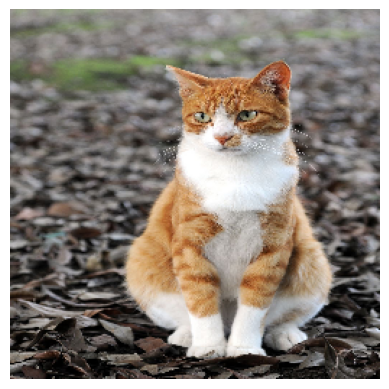

282



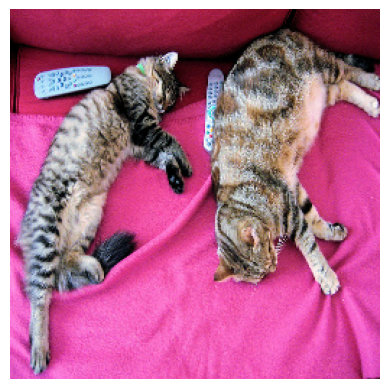

281



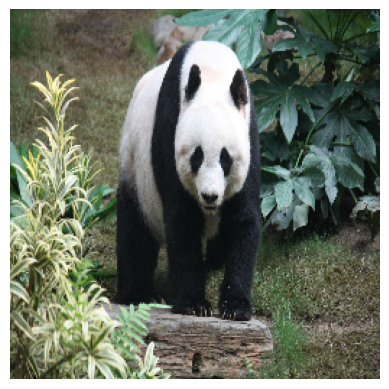

388



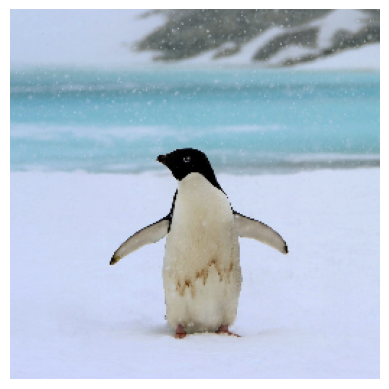

145

--------------
fastvit_t12
282

281

388

145

--------------
fastvit_s12
282

285

388

145

--------------
fastvit_sa12
282

281

388

145

--------------
fastvit_sa24
282

281

388

145

--------------
fastvit_sa36
282

281

388

145

--------------
fastvit_ma36
282

285

388

145

--------------


In [13]:
show = True
img_shape = (256, 256)

for model_fn in keras_models_fns:
    print(model_fn.__name__)
    keras_model = model_fn(inference_mode=False)    
    keras_model.load_weights(rf"keras_fastvit_weights\kd\keras_{model_fn.__name__}_kd.weights.h5")
    # keras_model.summary()

    test_prediction(image_path=r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision\test_images\cat.jpg", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision\test_images\cat_2.JPG", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision\test_images\pandas.JPG", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision\test_images\penguin.JPG", model=keras_model, image_shape=img_shape, show=show)
    print("--------------")
    show=False
    # break
